In [6]:
import pandas as pd
import os
import random
import PIL.Image
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

In [2]:
def load_image(path, mode='RGB'):
    return PIL.Image.open(path)


def to_array(image):
    return np.asarray(image)


def to_image(array, mode='RGB'):
    return PIL.Image.fromarray(np.uint8(array), mode=mode)

def resize(image, size):
    return tf.image.resize(image, size)


def resize_smallest_side_different_scales(image, smallest_side_to=(128, 256, 384)):
    height, width = to_array(image).shape[:2]
    scaled_list = []

    if height < width:

        for scale in smallest_side_to:
            scaled = tf.image.resize(image, (scale, width))
            scaled_list.append(scaled)

        return scaled_list

    else:

        for scale in smallest_side_to:
            scaled = tf.image.resize(image, (height, scale))
            scaled_list.append(scaled)

        return scaled_list


def resize_with_aspect_ratio(image, target_width=(128, 256, 512), input_shape=(224, 224)):
    h, w = to_array(image).shape[:2]
    r = h / w
    resized = []

    for width in target_width:
        resized_h = int(r * width)
        resized_img = resize(image, (resized_h, width))
        resized.append(to_image(tf.image.resize_with_crop_or_pad(resized_img, input_shape[0], input_shape[1])))

    return resized


def bounding_boxes(offsets, dim):
    boxes = []

    for i in offsets:
        offset_height, offset_width = i
        target_height, target_width = dim
        boxes.append([offset_height, offset_width, target_height, target_width])

    return boxes


def random_sectioning(image, offsets, dims):
    boxes = bounding_boxes(offsets, dims)
    image_sections = []
    height, width = to_array(image).shape[:2]
    
    if (height < height//2 + dims[0]) and (width < width//2 + dims[1]):
        image = tf.image.resize(image, (dims[0]*2, dims[1]*2))
    
    if (height > height//2 + dims[0]) and (width < width//2 + dims[1]):
        image = tf.image.resize(image, (height, dims[1]*2))
    
    if (height < height//2 + dims[0]) and (width > width//2 + dims[1]):
        image = tf.image.resize(image, (dims[0]*2, width))

    for box in boxes:
        if random.choice([True, False]):
            section = tf.image.crop_to_bounding_box(image, box[0], box[1], box[2], box[3])
            image_sections.append(section)

    return image_sections


def aggressive_cropping(image, copies, crop_window, resize_smallest_side=None, output_shape=(224, 224)):
    global resized_copies

    if resize_smallest_side is not None:
        if isinstance(resize_smallest_side, int):
            img = resize(to_array(image), (resize_smallest_side, resize_smallest_side))

        if isinstance(resize_smallest_side, (list, tuple)):
            resized_copies = [tf.image.resize(to_array(image), (size, size)) for size in resize_smallest_side]

    if isinstance(crop_window, int):
        crops = [tf.image.random_crop(to_array(image), (crop_window, crop_window)) for _ in range(copies)]

        return [resize(crop_img, output_shape) for crop_img in crops]

    elif isinstance(crop_window, (list, tuple)):
        crops = [tf.image.random_crop(to_array(image), crop_window) for _ in range(copies)]

        return [resize(crop_img, output_shape) for crop_img in crops]

## Pipeline

In [3]:
def pipeline(file_name, src, dst, label):
    processed = []
    image = load_image(os.path.join(src, file_name))
    height, width = to_array(image).shape[:2]

    sections = random_sectioning(to_array(image),
                                 [[0, 0], [height // 2, 0], [0, width // 2], [height // 2, width // 2],
                                  [height // 4, width // 4]],
                                 [224, 224])
    resize_small_side = resize_smallest_side_different_scales(to_array(image), (224, 256, 384))
    resized_with_aspect_ratio = resize_with_aspect_ratio(to_array(image))
    resized_original = tf.image.resize_with_pad(to_array(image), 224, 224)

    for i, arr in enumerate(sections):
        filename = f'r-sec-{i}-{file_name}'
        processed.append([filename, label])
        to_image(arr).save(os.path.join(dst, filename))

    for i, arr in enumerate(resized_with_aspect_ratio):
        filename = f'r-to-ar-{i}-{file_name}'
        processed.append([filename, label])
        to_image(arr).save(os.path.join(dst, filename))

    for img in resize_small_side:
        rand_crop = aggressive_cropping(to_image(img), 4, (224, 224, 3))

        for i, arr in enumerate(rand_crop):
            filename = f'agr-crop-{i}-{file_name}'
            processed.append([filename, label])
            to_image(arr).save(os.path.join(dst, filename))
            
    to_image(resized_original).save(os.path.join(dst,file_name))
    
    return processed

In [4]:
train_meta = pd.read_csv('../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv')
train_meta

In [ ]:
src = '../input/sorghum-id-fgvc-9/train_images/'
dst = 'train'
meta = []

if not os.path.isdir(dst):
    os.mkdir(dst)

for i in range(train_meta.shape[0]):
    file, label = train_meta.iloc[i]
    
    if os.path.exists(os.path.join(src, file)):
        temp = pipeline(file, src, dst, label)
        meta.append(temp)
    
    print(f'{i + 1}/{train_meta.shape[0]}', end='\r')

## transfer

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
pre_trained = InceptionV3(include_top=False)
pre_trained.layers

In [3]:
pre_trained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

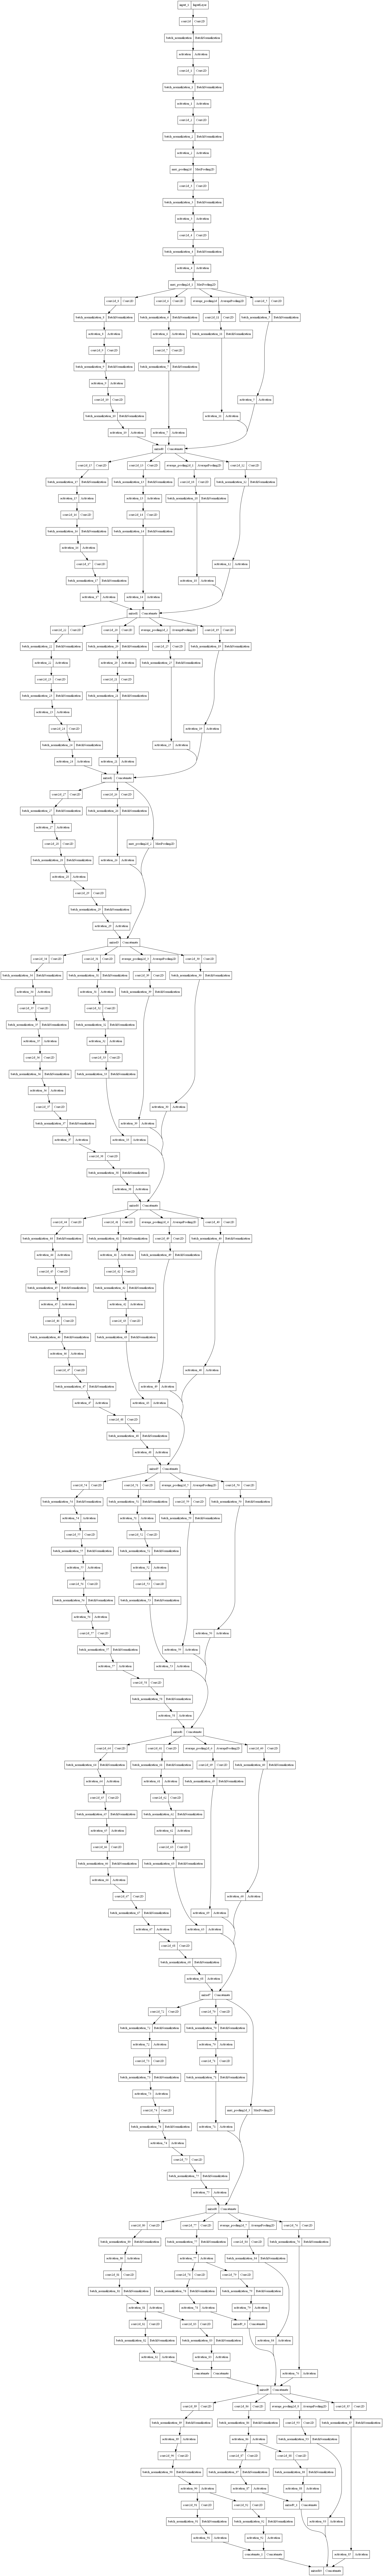

In [7]:
plot_model(pre_trained)

In [4]:
pre_trained.get_layer('mixed5')

In [5]:
for layer in pre_trained.layers[:pre_trained.get_layer('mixed5')]:
    print(layer)

TypeError: slice indices must be integers or None or have an __index__ method